In [322]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt 
from scipy import signal
from scipy import optimize
from scipy import ndimage
from math import erf
plt.style.use('cashaback_dark')
from tqdm import tqdm

Creating my own truncated normal class

In [323]:
class truncnorm():
    def __init__(self,x,cut_off_a,cut_off_b,mu,sig):
        self.x = x
        self.cut_off_a = cut_off_a
        self.cut_off_b = cut_off_b
        self.mu = mu
        self.sig = sig
        self.timing_sd = 3
    def norm_pdf(self):
        return (1/(self.sig*np.sqrt(2*np.pi)))*np.e**((-0.5)*((self.x-self.mu)/self.sig)**2)
    def norm_cdf(self):
        '''
        Cumulative distribution function for the standard normal distribution
        '''
        
        return (1.0 + erf(self.x / np.sqrt(2.0))) / 2.0
    
    def pdf(self):
        ans = np.zeros(len(self.x))
        a, b = (self.cut_off_a - self.mu)/self.sig, (self.cut_off_b - self.mu) / self.sig
        for i,r in enumerate(self.x):
            if r<=self.cut_off_a or r>=self.cut_off_b:
                ans[i] = 0
            else:
                N = ((stats.norm.pdf(r,self.mu,self.sig)))
                D = ((stats.norm.cdf(self.cut_off_b,self.mu,self.sig)) - (stats.norm.cdf(self.cut_off_a,self.mu,self.sig)))
                ans[i] = N
        return ans
    
    def pdf_uncertain(self):
        ans = np.zeros(len(self.x))
        a, b = (self.cut_off_a - self.mu)/self.sig, (self.cut_off_b - self.mu) / self.sig
        for i,r in enumerate(self.x):
            if r<=self.cut_off_a:
                ans[i] = 0
            elif r>=self.cut_off_b:
                N = stats.norm.pdf(r,self.mu,self.sig)
                # mean_diff = self.mu - self.cut_off_b
                # sigma_diff = np.sqrt(self.sig**2 + self.timing_sd**2)
                # self.prob_x_greater_b = 1 - stats.norm.cdf(0,mean_diff,sigma_diff)
                # ans[i] = N/D
                mean_diff = self.mu - self.cut_off_b
                sigma_diff = np.sqrt(self.sig**2 + self.timing_sd**2)
                self.prob_less_0 = stats.norm.cdf(0,mean_diff,sigma_diff) # Probablity that the random time selected is greater than the agent time selected
                self.certan_prob = stats.norm.cdf(self.cut_off_b,self.mu,self.sig)
                D = self.prob_less_0 - stats.norm.cdf(self.cut_off_a,self.mu,self.sig)
                ans[i] = N/(D)
            else:
                N = (stats.norm.pdf(r,self.mu,self.sig))
                mean_diff = self.mu - self.cut_off_b
                sigma_diff = np.sqrt(self.sig**2 + self.timing_sd**2)
                self.prob_less_0 = stats.norm.cdf(0,mean_diff,sigma_diff) # Probablity that the random time selected is greater than the agent time selected
                self.certan_prob = stats.norm.cdf(self.cut_off_b,self.mu,self.sig)
                D = self.prob_less_0 - stats.norm.cdf(self.cut_off_a,self.mu,self.sig)
                ans[i] = N/D
        return ans
    
    def cdf(self):
        ans = np.zeros(len(self.x))
        a, b = (self.cut_off_a - self.mu)/self.sig, (self.cut_off_b - self.mu) / self.sig
        for i,r in enumerate(self.x):
            if r <= self.cut_off_a: 
                ans[i] = 0
            elif r >= self.cut_off_b:
                ans[i] = 1
            else:
                N = ((stats.norm.cdf(r,self.mu,self.sig) - stats.norm.cdf(self.cut_off_a,self.mu,self.sig)))
                D = ((stats.norm.cdf(self.cut_off_b,self.mu,self.sig)) - (stats.norm.cdf(self.cut_off_a,self.mu,self.sig)))
                ans[i] = N/D
        return ans

UNcertain pdf check

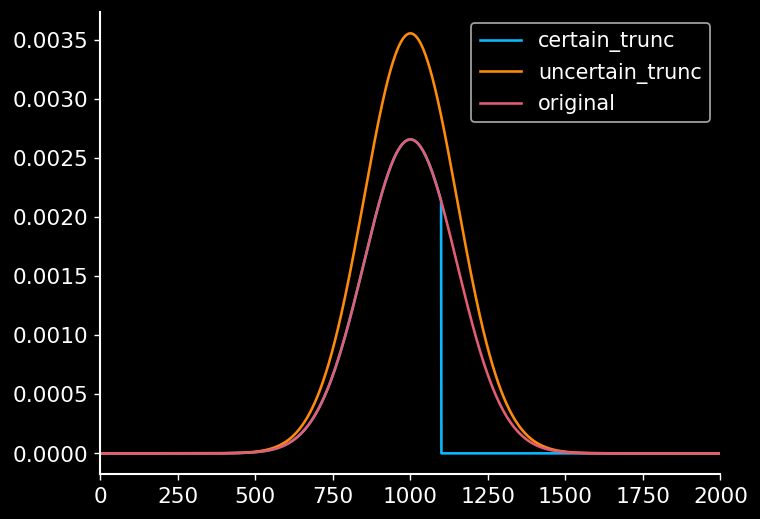

In [324]:
timesteps = np.arange(0,2000,1)
cut_off_a,cut_off_b = -2000,1100
mu,sig = 1000,150
original_agent_pdf = stats.norm.pdf(timesteps,mu,sig)
a, b = (cut_off_a - mu)/sig, (cut_off_b - mu) / sig
trunc = truncnorm(timesteps,cut_off_a,cut_off_b,mu,sig)
pdf_certain = trunc.pdf()

fig,ax = plt.subplots()
ax.plot(timesteps,pdf_certain,label='certain_trunc')
pdf_uncertain = trunc.pdf_uncertain()
ax.plot(timesteps,pdf_uncertain,label='uncertain_trunc')
ax.set_xlim(0,2000)

time_pdf = stats.norm.pdf(timesteps,cut_off_b,70)
new = pdf_uncertain*time_pdf/(pdf_uncertain+time_pdf)
# ax.plot(timesteps,new)
ax.plot(timesteps,original_agent_pdf,label='original')
# ax.plot(timesteps,time_pdf)
ax.legend()


In [325]:
trunc.prob_less_0

0.7474648802675167

In [326]:
trunc.certan_prob

0.7475074624530771

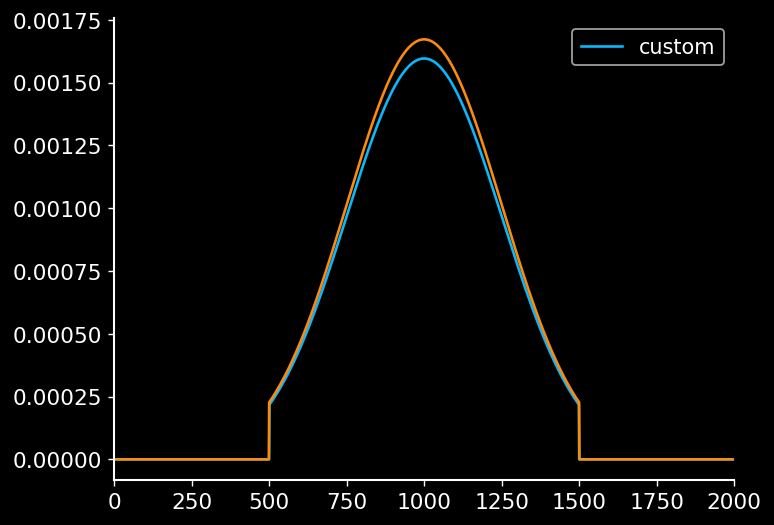

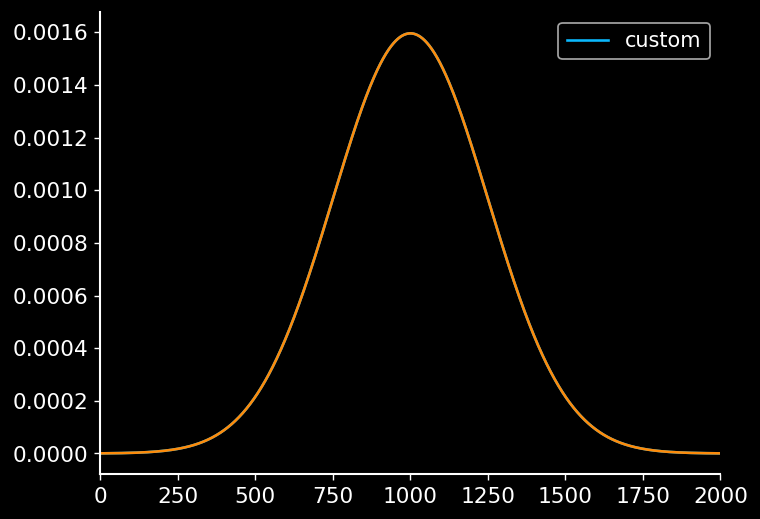

In [327]:
timesteps = np.arange(0,2000,1)
cut_off_a,cut_off_b = 500,1500
mu,sig = 1000,250
a, b = (cut_off_a - mu)/sig, (cut_off_b - mu) / sig
trunc = truncnorm(timesteps,cut_off_a,cut_off_b,mu,sig)
me = trunc.pdf()
me2 = trunc.norm_pdf()
them = stats.truncnorm.pdf(timesteps,a,b,mu,sig)
them2 = stats.norm.pdf(timesteps,mu,sig)
fig,ax = plt.subplots()
ax.plot(timesteps,me,label='custom')
ax.plot(timesteps,them)
ax.set_xlim(0,2000)
ax.legend()
fig,ax = plt.subplots()
ax.plot(timesteps,me2,label='custom')
ax.plot(timesteps,them2)
ax.set_xlim(0,2000)
ax.legend()

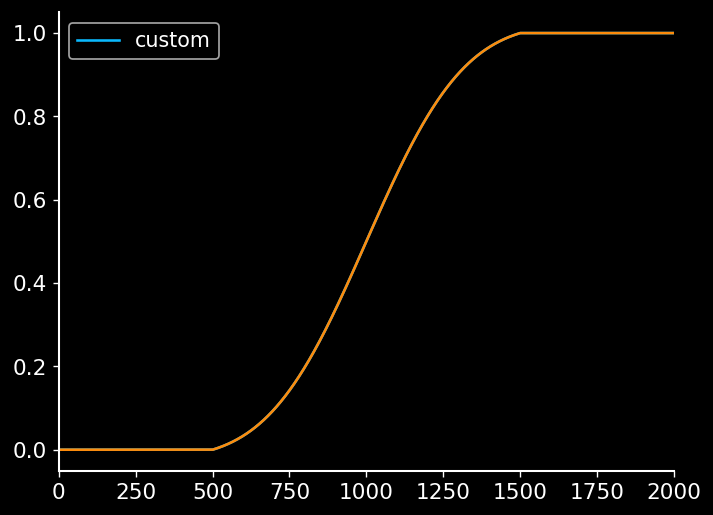

In [328]:
timesteps = np.arange(0,2000,1)
cut_off_a,cut_off_b = 500,1500
mu,sig = 1000,250
a, b = (cut_off_a - mu)/sig, (cut_off_b - mu) / sig

me = trunc.cdf()
them = stats.truncnorm.cdf(timesteps,a,b,mu,sig)
fig,ax = plt.subplots(dpi=124)
ax.plot(timesteps,me,label='custom')
ax.plot(timesteps,them)
ax.set_xlim(0,2000)
ax.legend()

Uncertain pdf

Instead of thinking about cutoff times, just get the distribution that gives the probability that the player cut off time will be greater than the agent's decision time

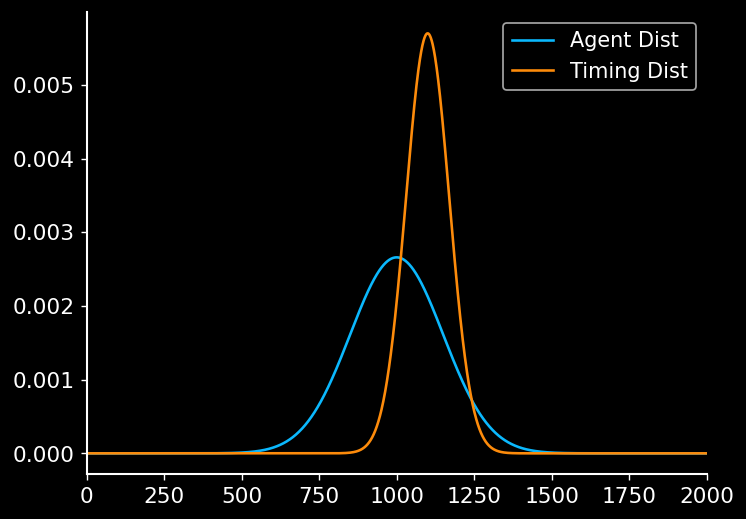

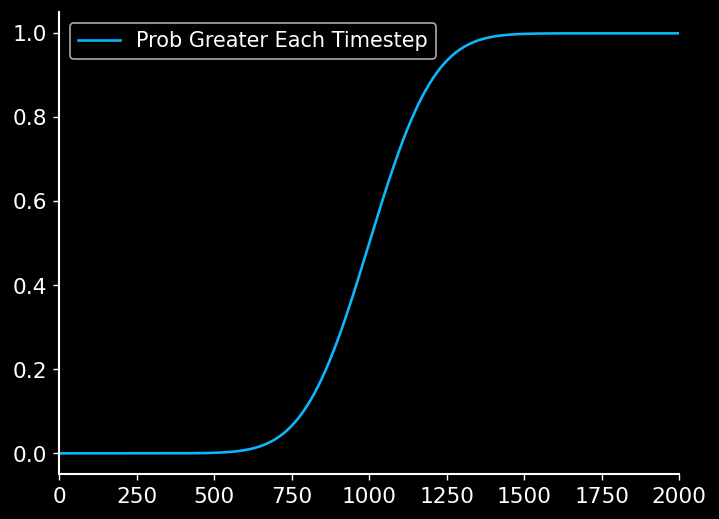

In [329]:
timesteps = np.arange(0,2000,1)
mu,sd = 1000,150
agent_dist = stats.norm.pdf(timesteps,mu,sd)

cut_time = 1100
timing_dist = stats.norm.pdf(timesteps,cut_time,70)

prob_greater = 1 - stats.norm.cdf(0,timesteps- mu,np.sqrt(sd**2+70**2))

fig,ax = plt.subplots(dpi=125)
ax.plot(timesteps,agent_dist,label='Agent Dist')
ax.plot(timesteps,timing_dist,label='Timing Dist')

ax.set_xlim(0,2000)

ax.legend()
plt.show()
fig,ax = plt.subplots(dpi=125)
ax.plot(timesteps,prob_greater,label='Prob Greater Each Timestep')
ax.set_xlim(0,2000)

ax.legend()
plt.show()



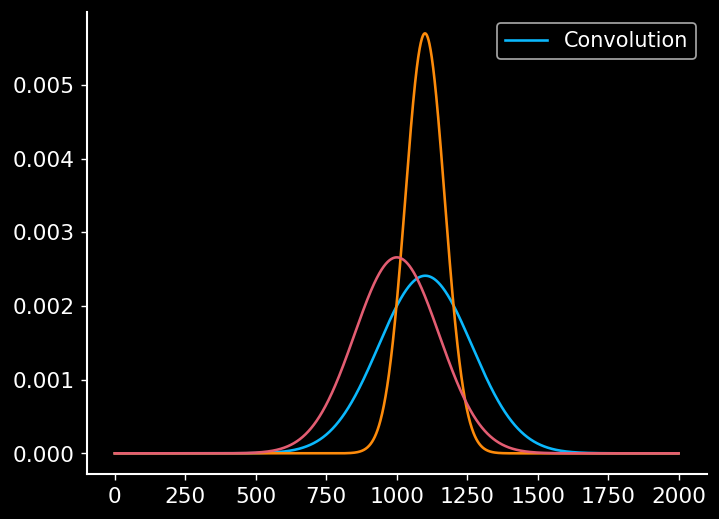

In [330]:
conv = signal.fftconvolve(agent_dist,timing_dist,mode='same')
conv2= signal.fftconvolve(timing_dist,agent_dist)
fig,ax = plt.subplots()
ax.plot(conv,label='Convolution')
ax.plot(timesteps,timing_dist)
# ax.plot(agent_dist*timing_dist/np.sum(agent_dist*timing_dist))
ax.plot(timesteps,agent_dist)
ax.legend()

Cut off with certain cut off time

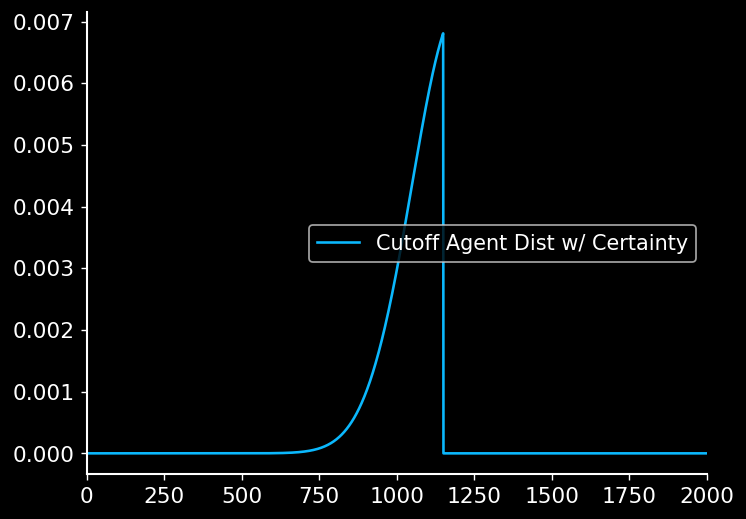

In [331]:
t = np.arange(0,2000,1)
cut_off_a =-np.inf
cut_off_b = 1150

mu,sd = 1200,150
a, b = (cut_off_a - mu)/sd, (cut_off_b - mu) / sd
norm_pdf = stats.norm.pdf(t,mu,sd)
cutoff_pdf_certain = stats.truncnorm.pdf(t,a,b,loc=mu,scale=sd) 
timing_pdf = stats.norm.pdf(t,)

fig,ax = plt.subplots(dpi=125)
ax.plot(t,cutoff_pdf_certain,label='Cutoff Agent Dist w/ Certainty')
ax.set_xlim(0,2000)

ax.legend()
plt.show()

In [332]:
x = stats.truncnorm.stats(a,b,loc=mu,scale=sd) 
x

(array(1046.77544715), array(6683.46404621))

Simulating 10000 truncnorm pdfs with the cut off time as the random variable

In [333]:
t = np.arange(0,2000,1)
mu,sd = 1200,150
cut_off_a,cut_off_b =-np.inf, 1200
iterations = 10000

every_pdf = np.zeros((iterations,len(t)))
cut_off_b_rvs = stats.norm.rvs(cut_off_b,70,iterations)
a, b, b_rvs = (cut_off_a - mu)/sd,(cut_off_b - mu) / sd, (cut_off_b_rvs - mu) / sd
for i in range(iterations):
    every_pdf[i,:] = stats.truncnorm.pdf(t,a,b_rvs[i],loc=mu,scale=sd)
cutoff_pdf_uncertain = np.mean(every_pdf,axis=0)
norm_pdf = stats.norm.pdf(t,mu,sd)
cutoff_pdf_certain = stats.truncnorm.pdf(t,a,b,loc=mu,scale=sd) 
mean_certain_cutoff = stats.truncnorm.stats(a,b,loc=mu,scale=sd,moments='m')



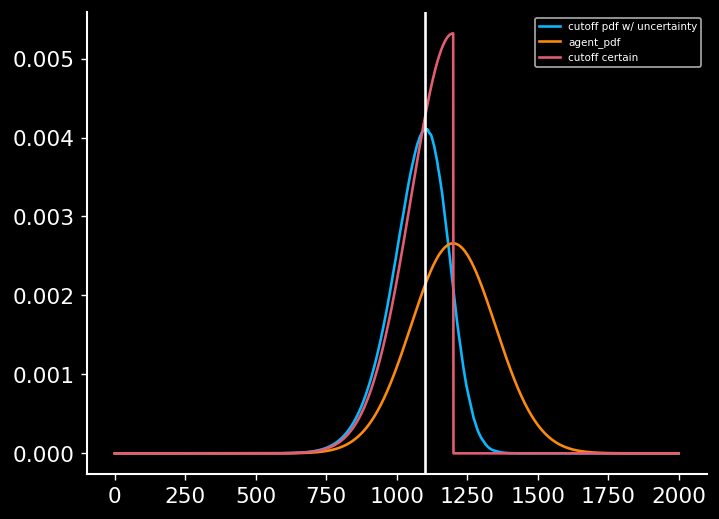

1100
1080.3173158795703


In [334]:
# timing_pdf_at_cutoff = stats.norm.pdf(t,cut_off_b,70) # Likelihood
# skewnorm = stats.skewnorm.pdf(t,-0.15,1068,sd-55)

fig,ax = plt.subplots(dpi=125)
ax.plot(t,cutoff_pdf_uncertain,label='cutoff pdf w/ uncertainty')
ax.plot(t,norm_pdf,label='agent_pdf')
ax.plot(t,cutoff_pdf_certain,label='cutoff certain')
# ax.plot(t,skewnorm,label='skewnorm')
# ax.plot(t,timing_pdf_at_cutoff,label='timing pdf')
# ax.plot(t,pdf)
# for i in range(100):
#     ax.plot(t,every_pdf[i,:])
# ax.set_xlim(0,2000)
# ax.axvline(x=1046)
ax.axvline(x=np.argmax(cutoff_pdf_uncertain))
ax.legend(fontsize=6)
plt.show()
print(np.argmax(cutoff_pdf_uncertain))
print(mean_certain_cutoff)


Can I do the convolution of timing pdf with agent pdf to get the new pdf that the person will see?

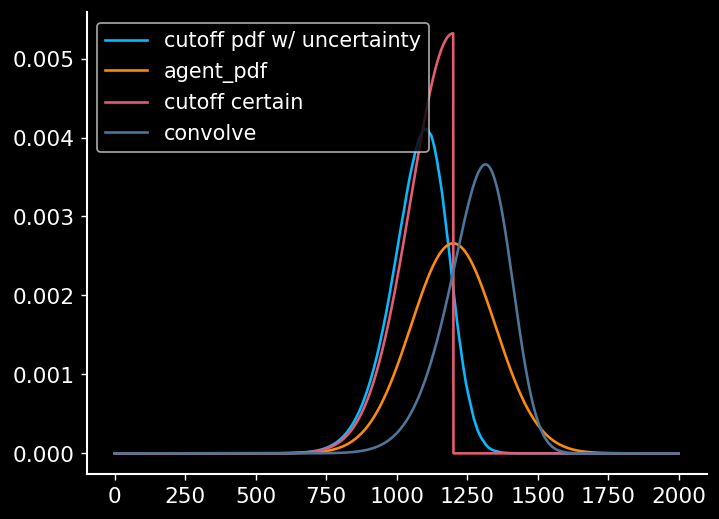

In [335]:
timing_pdf_at_cutoff = stats.norm.pdf(t,cut_off_b,70) # Likelihood
norm_pdf = stats.norm.pdf(t,mu,sd)
conv = signal.fftconvolve(timing_pdf_at_cutoff,norm_pdf,mode='same')
conv2 = signal.fftconvolve(cutoff_pdf_certain,norm_pdf,mode='same')
conv3 = signal.fftconvolve(timing_pdf_at_cutoff,cutoff_pdf_certain,mode='same')
fig,ax = plt.subplots(dpi=125)
ax.plot(t,cutoff_pdf_uncertain,label='cutoff pdf w/ uncertainty')
ax.plot(t,norm_pdf,label='agent_pdf')
ax.plot(t,cutoff_pdf_certain,label='cutoff certain')
ax.plot(conv3,label='convolve')
# ax.plot(t,timing_pdf_at_cutoff,label='timing pdf')

ax.legend()
plt.show()

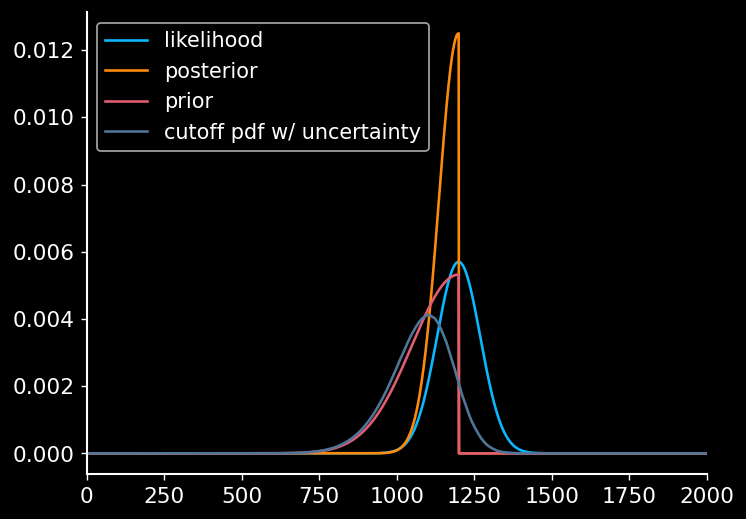

In [336]:
agent_pdf = stats.norm.pdf(t,mu,sd) # Prior
timing_pdf_at_cutoff = stats.norm.pdf(t,cut_off_b,70) # Likelihood
like = timing_pdf_at_cutoff
prior = cutoff_pdf_certain
like_norm = like/np.sum(like)
prior_norm = prior/np.sum(prior)
posterior = (like_norm*prior_norm)/np.sum(like_norm*prior_norm)
# cutoff_cdf_certain = stats.truncnorm.cdf(t,a,b,mu,sd)
fig,ax = plt.subplots(dpi=125)
ax.plot(t,like,label='likelihood')
# ax.plot(t,agent_pdf,label='agent')
ax.plot(t,posterior,label='posterior')
ax.plot(t,prior,label='prior')
ax.plot(t,cutoff_pdf_uncertain,label='cutoff pdf w/ uncertainty')
ax.set_xlim(0,2000)
ax.legend()
plt.show()



Convolution of hard cut off and soft cut off with reaction movement time

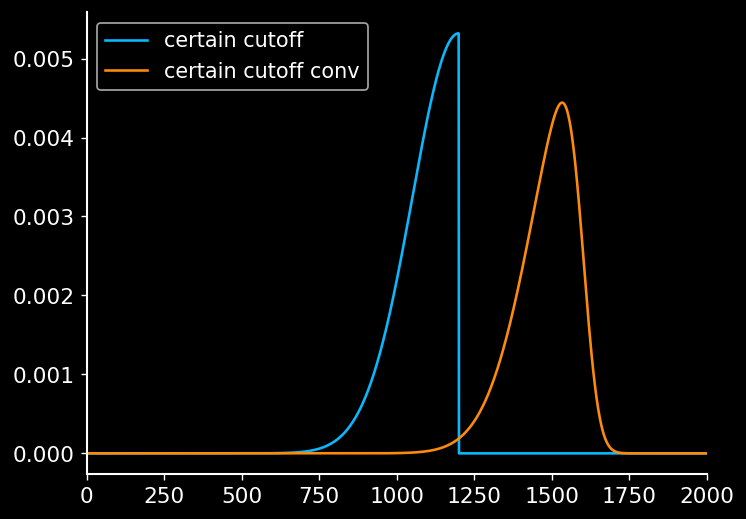

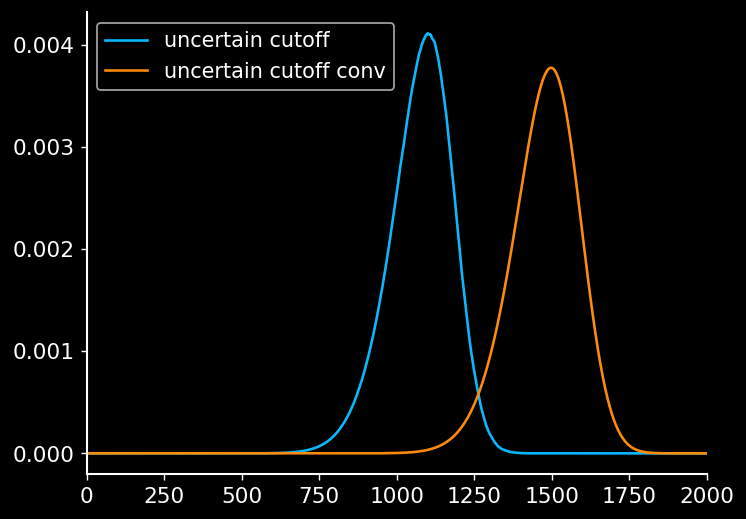

In [337]:
dx=1
rmt = stats.norm.pdf(t,400,40)
hard_rmt = signal.fftconvolve(cutoff_pdf_certain,rmt,mode='full') * dx
soft_rmt = signal.fftconvolve(cutoff_pdf_uncertain,rmt,mode = 'full')* dx
fig,ax = plt.subplots(dpi=125)
ax.plot(cutoff_pdf_certain,label='certain cutoff')
ax.plot(hard_rmt,label='certain cutoff conv')
ax.legend()
ax.set_xlim(0,2000)
plt.show()

fig,ax = plt.subplots(dpi=125)
ax.plot(cutoff_pdf_uncertain,label='uncertain cutoff')
ax.plot(soft_rmt,label='uncertain cutoff conv')
ax.legend()
ax.set_xlim(0,2000)
plt.show()

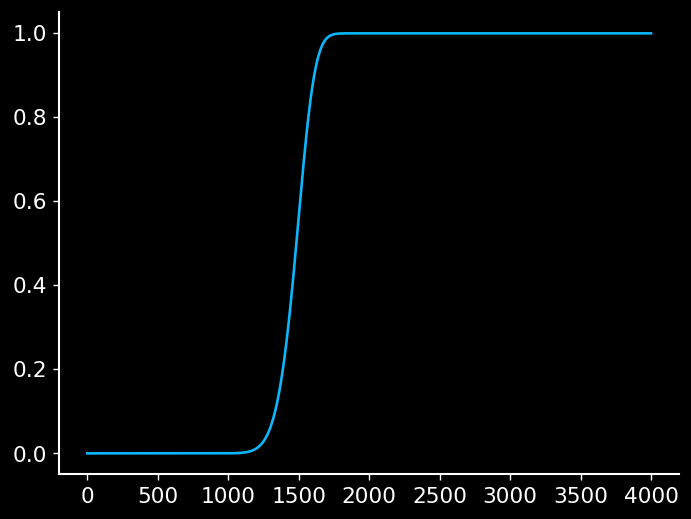

In [338]:
plt.plot(np.cumsum(soft_rmt))

Figure out how to simulate the uncertain distribution for each timestep

In [339]:
# iterations = 10000
# timesteps = np.arange(0,2000,1)
# timing_uncertainty = 70
# cut_off_a = -10000000
# every_pdf = np.zeros((iterations,2000))
# cut_off_b_rvs = stats.norm.rvs(timesteps,timing_uncertainty,size = (10000,2000))

# mu,sd = 1000,150
# a, b_rvs = (cut_off_a - mu)/sd, (cut_off_b_rvs - mu) / sd
# every_pdf = np.zeros((iterations,2000,2000))
# for i in range(iterations):
#     for k in range(len(timesteps)):
#         every_pdf[i,k,:] = stats.truncnorm.pdf(timesteps,a,cut_off_b_rvs[i,k],loc=mu,scale=sd)

In [340]:
def screw_you_john(params,true_pdf):
    pdf_params = stats.skewnorm.pdf(t,params[0],params[1],params[2])
    log_params = np.log(pdf_params, out=np.zeros_like(pdf_params), where=(pdf_params!=0))
    log_true = np.log(true_pdf, out=np.zeros_like(true_pdf), where=(true_pdf!=0))
    mse = np.sum(np.abs(pdf_params-true_pdf))
    
    is_negative = params<=0
    if is_negative.any():
        return 1e6
    return mse

In [341]:
init_skew,init_mean,init_sd = 2,300,50
bnds = ((-10,10),(300,2000),(0,500))
t = np.arange(0,2000,1)
mu,sd = 1200,150
cut_off_a,cut_off_b =-np.inf, 1000
iterations = 10000

every_pdf = np.zeros((iterations,len(t)))
cut_off_b_rvs = stats.norm.rvs(cut_off_b,1,iterations)
a, b, b_rvs = (cut_off_a - mu)/sd,(cut_off_b - mu) / sd, (cut_off_b_rvs - mu) / sd
for i in range(iterations):
    every_pdf[i,:] = stats.truncnorm.pdf(t,a,b_rvs[i],loc=mu,scale=sd)
uncertain_trunc_pdf = np.mean(every_pdf,axis=0)

optim = optimize.minimize(screw_you_john,[init_skew,init_mean,init_sd],args=(uncertain_trunc_pdf),method='Nelder-Mead',bounds = bnds,
                          options = {"maxiter": 1e6,"maxfev": 1e6, "fatol":0.000000001,"disp": True})
optim.x

Optimization terminated successfully.
         Current function value: 0.463821
         Iterations: 434
         Function evaluations: 760


array([7.06035144e-03, 9.49387332e+02, 5.23271564e+01])

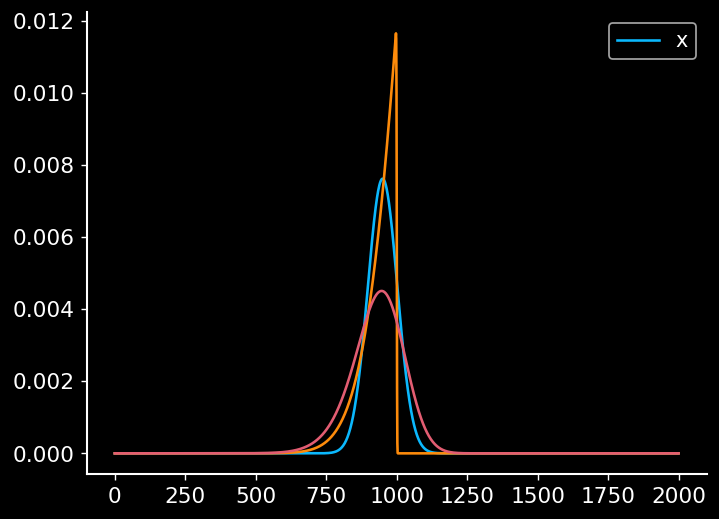

In [342]:
x = stats.skewnorm.pdf(t,optim.x[0],optim.x[1],optim.x[2])
fig,ax = plt.subplots()
plt.plot(x,label='x')
plt.plot(uncertain_trunc_pdf)
plt.plot(ndimage.gaussian_filter1d(uncertain_trunc_pdf,70))
ax.legend()

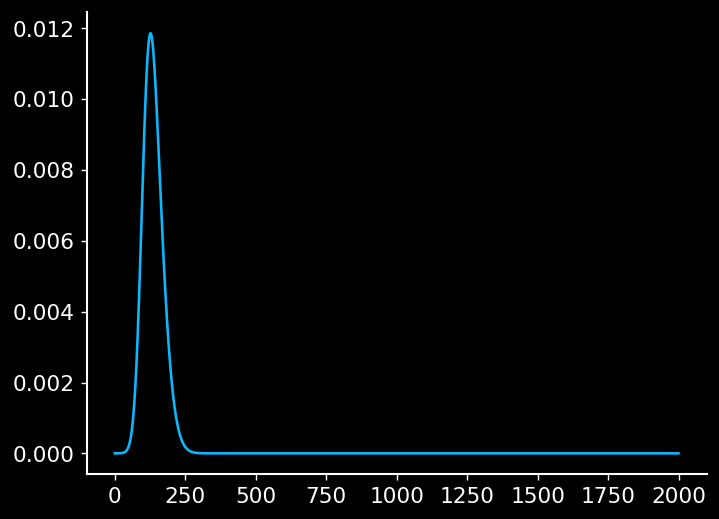

In [343]:
x = stats.skewnorm.pdf(t,2,100,50)
plt.plot(t,x)

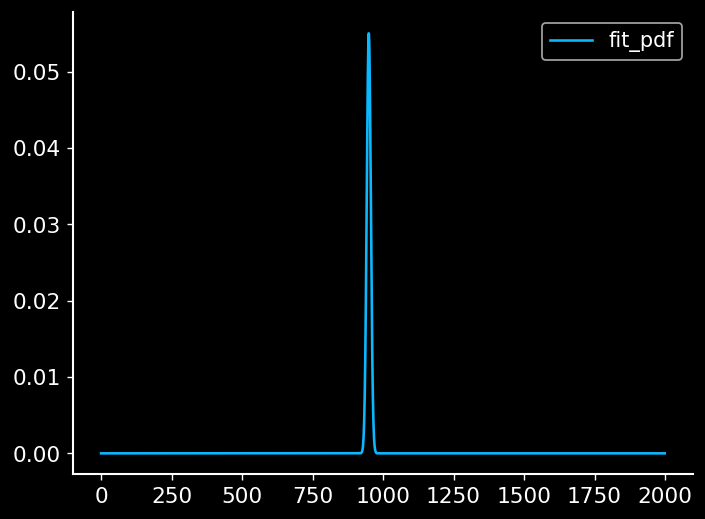

In [344]:
fit_pdf = stats.skewnorm.pdf(t,optim.x[0],optim.x[1],np.sqrt(optim.x[2]))
# fit_pdf = stats.skewnorm.pdf(t,1,2,10)
true_pdf = cutoff_pdf_uncertain

plt.show()
fig,ax = plt.subplots(dpi=125)
# ax.plot(true_pdf,label='true_pdf')
ax.plot(fit_pdf,label='fit_pdf')
ax.legend()

GAUSSIAN SMOOTHING

In [345]:
t = np.arange(0,2000,1)
mu,sd = 1200,150
cut_off_a,cut_off_b =-np.inf, 1200
iterations = 10000

every_pdf = np.zeros((iterations,len(t)))
cut_off_b_rvs = stats.norm.rvs(cut_off_b,70,iterations)
a, b, b_rvs = (cut_off_a - mu)/sd,(cut_off_b - mu) / sd, (cut_off_b_rvs - mu) / sd
for i in range(iterations):
    every_pdf[i,:] = stats.truncnorm.pdf(t,a,b_rvs[i],loc=mu,scale=sd)
cutoff_pdf_uncertain = np.mean(every_pdf,axis=0)
norm_pdf = stats.norm.pdf(t,mu,sd)
cutoff_pdf_certain = stats.truncnorm.pdf(t,a,b,loc=mu,scale=sd) 
mean_certain_cutoff = stats.truncnorm.stats(a,b,loc=mu,scale=sd,moments='m')

cut_max_id = np.argmax(cutoff_pdf_uncertain)

certain_cutoff_smoothed = ndimage.gaussian_filter1d(cutoff_pdf_certain,70)
# Idea is to only smooth from the cutoff onwards
certain_cutoff_smoothed_v2 = np.hstack((cutoff_pdf_certain[:cut_max_id],ndimage.gaussian_filter1d(cutoff_pdf_certain[cut_max_id:],70)))

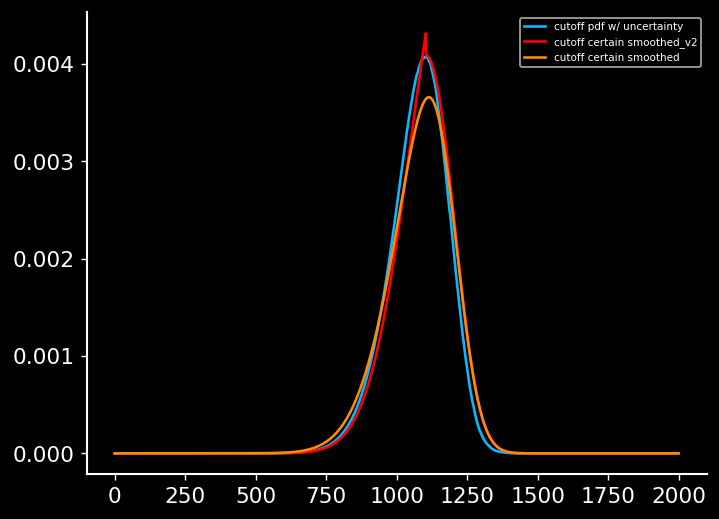

1104
1080.3173158795703


In [346]:
# timing_pdf_at_cutoff = stats.norm.pdf(t,cut_off_b,70) # Likelihood
# skewnorm = stats.skewnorm.pdf(t,-0.15,1068,sd-55)

fig,ax = plt.subplots(dpi=125)
# ax.plot(t,norm_pdf,label='agent_pdf')
# ax.plot(t,cutoff_pdf_certain,label='cutoff certain')
ax.plot(t,cutoff_pdf_uncertain,label='cutoff pdf w/ uncertainty')
ax.plot(t,certain_cutoff_smoothed_v2,label='cutoff certain smoothed_v2',color='red')
ax.plot(t,certain_cutoff_smoothed,label='cutoff certain smoothed')
# ax.plot(t,skewnorm,label='skewnorm')
# ax.plot(t,timing_pdf_at_cutoff,label='timing pdf')
# ax.plot(t,pdf)
# for i in range(100):
#     ax.plot(t,every_pdf[i,:])
# ax.set_xlim(0,2000)
# ax.axvline(x=1046)
# ax.axvline(x=np.argmax(cutoff_pdf_uncertain))
ax.legend(fontsize=6)
plt.show()
print(np.argmax(cutoff_pdf_uncertain))
print(mean_certain_cutoff)


In [347]:
t = np.arange(0,2000,1)
mu,sd = 1200,150
cut_off_a,cut_off_b =-np.inf, 1200
iterations = 10000

every_pdf = np.zeros((iterations,len(t)))
cut_off_b_rvs = stats.norm.rvs(cut_off_b,70,iterations)
a, b, b_rvs = (cut_off_a - mu)/sd,(cut_off_b - mu) / sd, (cut_off_b_rvs - mu) / sd
for i in range(iterations):
    every_pdf[i,:] = stats.truncnorm.pdf(t,a,b_rvs[i],loc=mu,scale=sd)
cutoff_pdf_uncertain = np.mean(every_pdf,axis=0)
norm_pdf = stats.norm.pdf(t,mu,sd)
cutoff_pdf_certain = stats.truncnorm.pdf(t,a,b,loc=mu,scale=sd) 
mean_certain_cutoff = stats.truncnorm.stats(a,b,loc=mu,scale=sd,moments='m')

Simulating the agent's distribution with uncertain cutoff time

In [348]:
cut_off_times = [2000,1300,1250,1200,1150,1100,1050,1000,950,900]
timing_sd = 150
agent_mean,agent_sd = 1200,150
for cut_off in cut_off_times:
    its = 100000
    cut_off_a,cut_off_b =-np.inf, cut_off
    rvs_agent = stats.norm.rvs(agent_mean,agent_sd,its)
    rvs_timing = stats.norm.rvs(cut_off_b,timing_sd,its)

    agent_mask = rvs_agent<=rvs_timing

    rvs_skewed_agent = rvs_agent*agent_mask
    rvs_skewed_agent[~agent_mask] = np.nan

    skew,mean,sd = stats.skewnorm.fit(rvs_agent[agent_mask],method='MM')

    skewnorm_fit = stats.skewnorm.pdf(t,skew,mean,sd)

    checker = rvs_agent

    fig,ax = plt.subplots(dpi=125)
    ax.hist(rvs_agent,bins=100,label='Agent Dist',density=True,zorder=0) 
    ax.hist(rvs_timing,bins=100,label='Timing Dist',density=True)
    ax.hist(rvs_skewed_agent,bins=100,label='Skewed Agent',alpha = 0.67,density=True)   
    # ax.plot(cutoff_pdf_uncertain)
    ax.plot(skewnorm_fit,c='white')
    ax.text(0,0.0015,f'Timing Mean (SD) = {cut_off_b} ({timing_sd})',fontsize = 10)
    ax.legend()
    plt.show()
    print(mean,sd**2,skew)
    a, b = (-100000 - agent_mean)/agent_sd, (cut_off_b - agent_mean) / agent_sd
    print(stats.truncnorm.stats(a,b,agent_mean,agent_sd,moments='mvsk'))

KeyboardInterrupt: 

Creating New PDF from convolution 

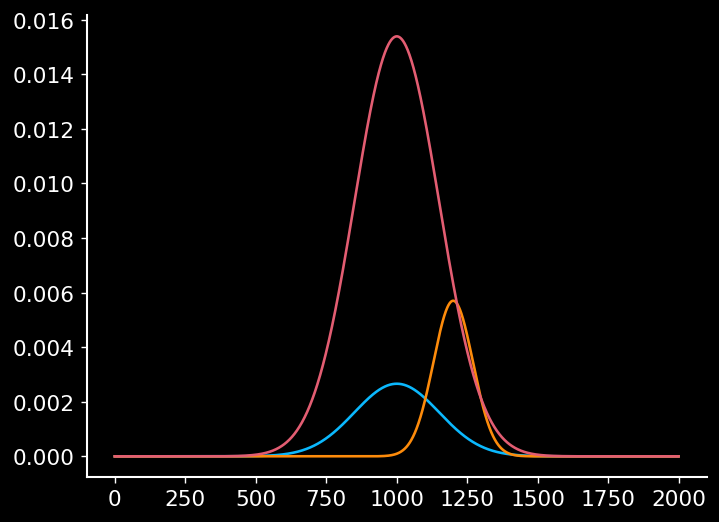

In [ ]:
time_range = np.arange(0,2000,1)
cut_off_time = 1200
timing_dist = stats.norm.pdf(time_range,loc=cut_off_time,scale=70)
agent_mu,agent_sd = 1000,150
agent_dist = stats.norm.pdf(time_range,loc=agent_mu,scale=agent_sd)
z = stats.norm.cdf(0,loc=cut_off_time - agent_mu,scale=np.sqrt(agent_sd**2 + agent_sd**2))
mult = (agent_dist/(z))
# NEed to convolution of X-Y
timing_dist_neg = stats.norm.pdf(-time_range,loc=cut_off_time,scale=70)
fig,ax = plt.subplots()
ax.plot(agent_dist)
ax.plot(timing_dist)
# ax.plot(z)
ax.plot(mult)
# ax.plot(np.cumsum(mult))
# ax.plot(conv)
# ax.plot(conv_check)
# ax.plot(conv)

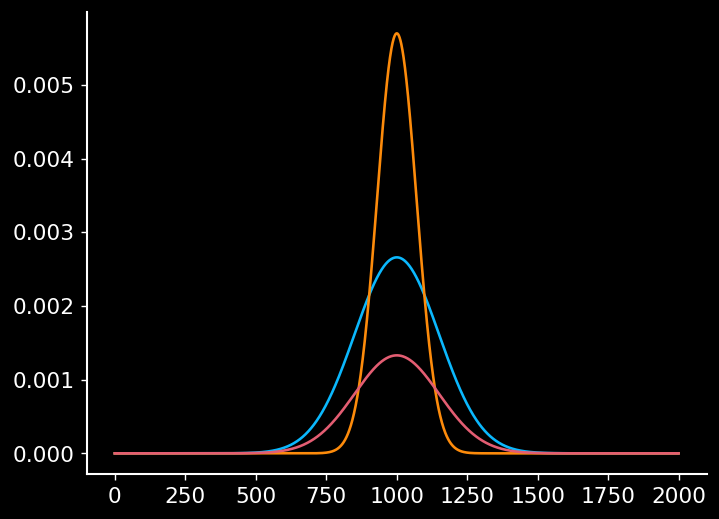

In [ ]:
time_range = np.arange(0,2000,1)
max_range = np.max(time_range)
cut_off_time = 1000
timing_dist = stats.norm.pdf(time_range,loc=cut_off_time,scale=70)
agent_mu,agent_sd = 1000,150
agent_dist = stats.norm.pdf(time_range,loc=agent_mu,scale=agent_sd)
prob_timing_greater_than_agent = stats.norm.cdf(0,loc=agent_mu-cut_off_time,scale=np.sqrt(agent_sd**2 + 70**2))
timing_prob = 1 - stats.norm.cdf(cut_off_time,loc=cut_off_time,scale=70)
new_dist = agent_dist*prob_timing_greater_than_agent
# NEed to convolution of X-Y
# timing_dist_neg = stats.norm.pdf(-time_range,loc=cut_off_time,scale=70)
# conv = signal.fftconvolve(agent_dist,timing_dist_neg,mode='same')
# conv_check = (stats.norm.pdf(-time_range,agent_mu,agent_sd)*stats.norm.pdf(time_range,cut_off_time,70))
fig,ax = plt.subplots()
ax.plot(agent_dist)
ax.plot(timing_dist)
ax.plot(new_dist)
# ax.plot(conv)
# ax.plot(conv_check)
# ax.plot(conv)

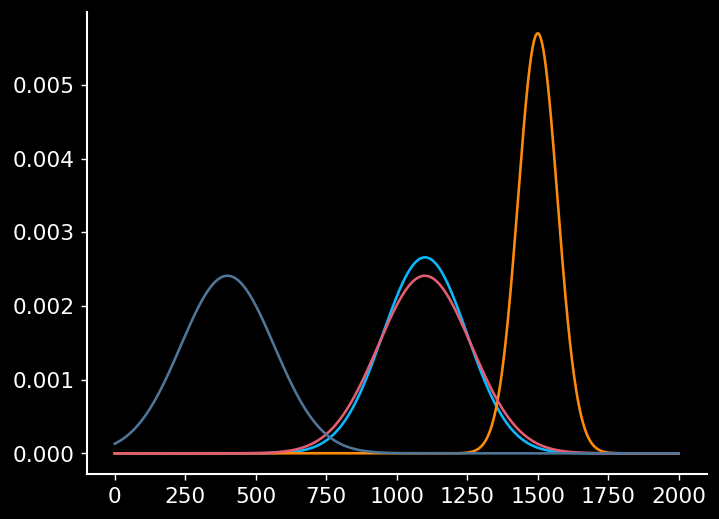

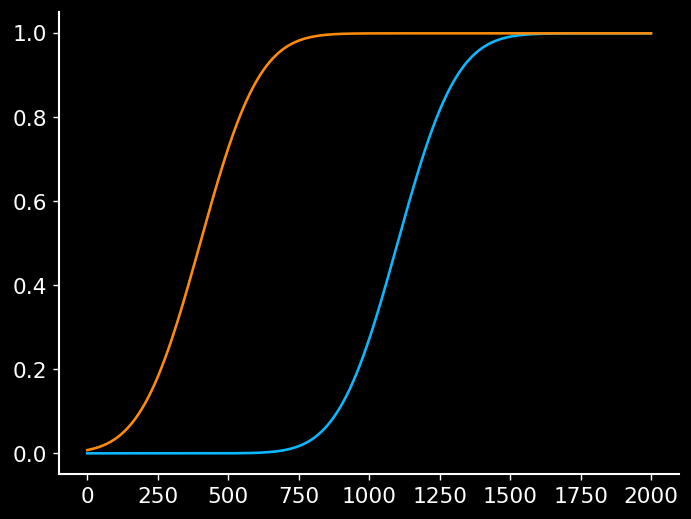

In [ ]:
time_range = np.arange(0,2000,1)
max_range = np.max(time_range)
cut_off_time = 1500
agent_mu,agent_sd = 1100,150
agent_cdf = stats.norm.cdf(time_range,loc=agent_mu,scale=agent_sd)
agent_pdf = stats.norm.pdf(time_range,loc=agent_mu,scale=agent_sd)
timing_pdf = stats.norm.pdf(time_range,loc=cut_off_time,scale=70)
timing_cdf = stats.norm.cdf(time_range,loc=cut_off_time,scale=70)

diff_cdf = 1 - stats.norm.cdf(0, loc=(time_range-agent_mu), scale=np.sqrt(agent_sd**2+70**2))
diff_cdf_specific = stats.norm.cdf(time_range, loc=(cut_off_time-agent_mu), scale=np.sqrt(agent_sd**2+70**2))
diff_pdf = np.diff(diff_cdf)
diff_pdf_specific = np.diff(diff_cdf_specific)
deriv_resp_time = np.diff
mult2 = timing_cdf*-agent_cdf
mult3 = np.diff(timing_cdf)*np.diff(agent_cdf)
dmult = -np.diff(mult2)
fig,ax = plt.subplots()
ax.plot(agent_pdf)
ax.plot(timing_pdf)
# ax.plot((dmult))
# ax.plot(mult3)
ax.plot((diff_pdf))
ax.plot((diff_pdf_specific))
# ax.hist(rvs_skewed_agent,bins=100,label='Skewed Agent',density=True)   

# ax.plot(mult)
# ax.plot(mult2)
plt.show()
fig,ax = plt.subplots()
ax.plot(diff_cdf)
ax.plot(diff_cdf_specific)

Using Double Sum to Match The CDF equations

In [349]:
timing_cdf = stats.norm.cdf(time_range,loc=cut_off_time,scale=70)
agent_cdf = stats.norm.cdf(time_range,loc=agent_mu,scale=agent_sd)
mult = np.cumsum(np.cumsum(agent_dist)*timing_dist) + np.cumsum(agent_dist*np.cumsum(timing_dist))


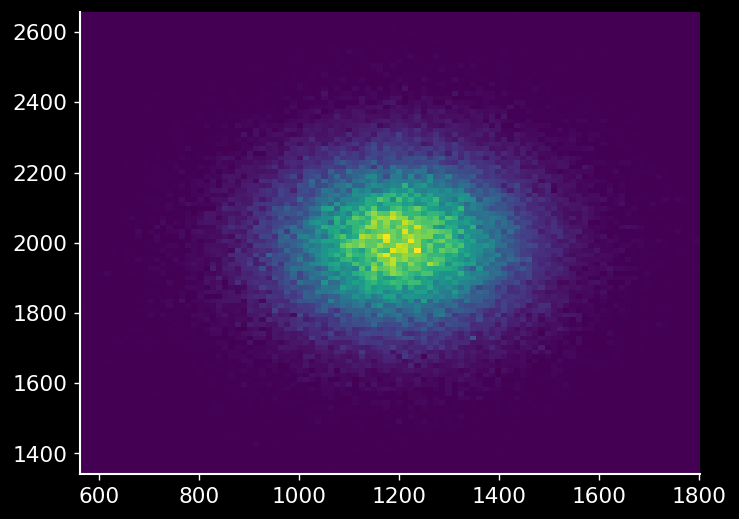

In [352]:
fig,ax = plt.subplots()
ax.hist2d(rvs_agent[agent_mask],rvs_timing[agent_mask],bins=(100,100),density=True)
# ax.hist2d(rvs_agent,rvs_skewed_agent,bins=(100,100),density=True)
plt.show()

Taking partial derivatives of double integral, going from two pdfs to to joint pdf

In [ ]:
f_st = timing_pdf*agent_pdf
np.diff(np.cumsum()

SyntaxError: unexpected EOF while parsing (1042610593.py, line 2)

In [ ]:
agent_means = [1000,1000,1100,1100,1200,1200]
agent_stds = [50,150,50,150,50,150]
timesteps = np.tile(np.arange(0,2000,1),(6,1))
tiled_agent_means = np.tile(agent_means,(2000,1)).T
tiled_agent_stds  = np.tile(agent_stds,(2000,1)).T
timing_uncertainty = 100

In [ ]:
its = 1000
rvs_agent = stats.norm.rvs(tiled_agent_means,tiled_agent_stds,size=(its,6,2000))
rvs_timing = stats.norm.rvs(timesteps,timing_uncertainty,size=(its,6,2000))




In [ ]:
agent_mask = rvs_agent<=rvs_timing
rvs_skewed_agent = rvs_agent*agent_mask
rvs_skewed_agent[~agent_mask] = np.nan
skew,mean,sd = np.zeros((6,2000))*np.nan,np.zeros((6,2000))*np.nan,np.zeros((6,2000))*np.nan
skewed_agent_pdf = np.zeros((6,2000,2000))*np.nan
for i in range(6):
    for j in tqdm(range(2000)):
        if np.count_nonzero(agent_mask[:,i,j])>500:
            agent_original = rvs_agent[:,i,j]
            fit_data = agent_original[agent_mask[:,i,j]]
            skew[i,j],mean[i,j],sd[i,j] = stats.skewnorm.fit(fit_data,loc = agent_means[i],scale = agent_stds[i])
            skewed_agent_pdf[i,j,:] = stats.skewnorm.pdf(timesteps[i,:],skew[i,j],mean[i,j],sd[i,j])
        else:
            continue

100%|██████████| 2000/2000 [02:06<00:00, 15.87it/s]  


In [ ]:
# agent_mask = rvs_agent<=rvs_timing
# rvs_skewed_agent = rvs_agent*agent_mask
# rvs_skewed_agent[~agent_mask] = np.nan
# skew,mean,sd = np.zeros((6,2000))*np.nan,np.zeros((6,2000))*np.nan,np.zeros((6,2000))*np.nan
# skewed_agent_pdf = np.zeros((6,2000,2000))*np.nan
# for i in range(6):
#     for j in range(2000):
#         if np.count_nonzero(agent_mask[:,i,j])>10:
#             agent_original = rvs_agent[:,i,j]
#             fit_data = agent_original[agent_mask[:,i,j]]
#             skew[i,j],mean[i,j],sd[i,j] = stats.skewnorm.fit(fit_data)
#             skewed_agent_pdf[i,j,:] = stats.skewnorm.pdf(timesteps[i,:],skew[i,j],mean[i,j],sd[i,j])
#         else:
#             continue

In [ ]:
rvs_agent.shape

(100, 6, 2000)

(array([0.00077104, 0.00154208, 0.00154208, 0.00539729, 0.00693938,
        0.01002354, 0.00462625, 0.00385521, 0.00616833, 0.00231313]),
 array([ 855.89980434,  879.05956345,  902.21932256,  925.37908168,
         948.53884079,  971.6985999 ,  994.85835901, 1018.01811812,
        1041.17787723, 1064.33763634, 1087.49739546]),
 <BarContainer object of 10 artists>)

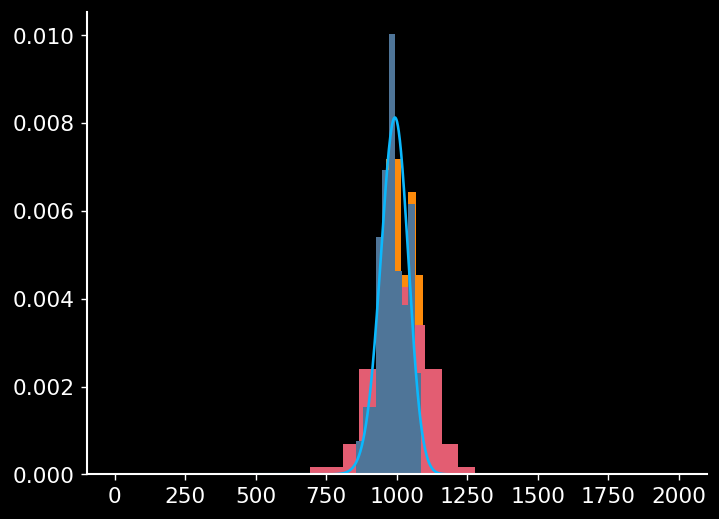

In [ ]:
fig,ax = plt.subplots()
ax.plot(skewed_agent_pdf[0,1000,:])
ax.hist(rvs_agent[:,0,1000],density=True)
ax.hist(rvs_timing[:,0,1000],density=True)
ax.hist(rvs_skewed_agent[:,0,1000],density=True)
# ax.plot(skewed_agent_pdf[1])
# ax.plot(skewed_agent_pdf[2])
# ax.plot(skewed_agent_pdf[3])
# ax.plot(skewed_agent_pdf[4])
# ax.plot(skewed_agent_pdf[5])

Gaussian Smoothing of an indicator function 

(0.0, 1.0)

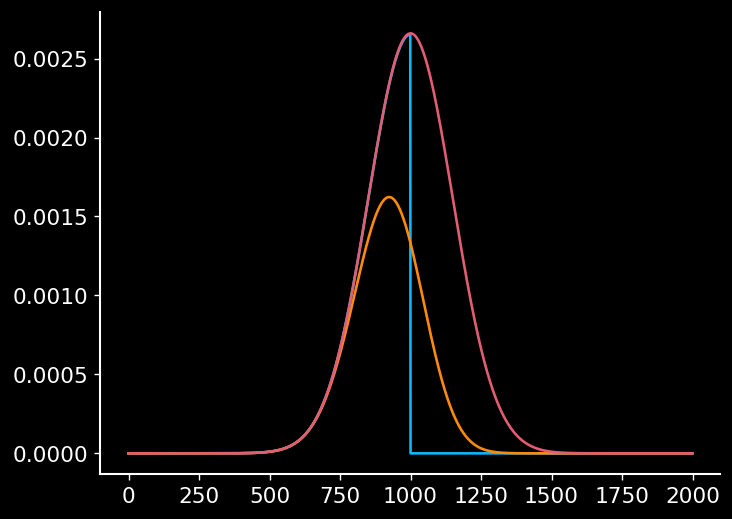

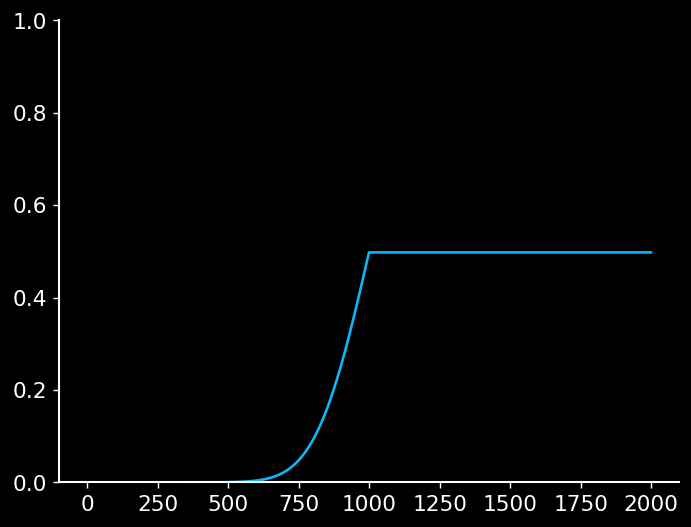

In [ ]:
cutoff_time,cutoff_sd = 1000,150
agent_mean,agent_sd = 1000,150
timesteps = np.arange(0,2000,1)
huge_timesteps = np.arange(-5000,2000,1)
agent_pdf = stats.norm.pdf(timesteps,agent_mean,agent_sd)
timing_pdf = stats.norm.pdf(timesteps,cutoff_time,cutoff_sd)
indicator_func = np.array([1 if x<cutoff_time else 0 for x in huge_timesteps])
indicator_func_smooth_check = 1-stats.norm.cdf(timesteps,cutoff_time,cutoff_sd)
indicator_func_smooth = np.convolve(indicator_func,timing_pdf,mode='same')[5000:]
prob_cut_greater_agent = 1 - stats.norm.cdf(0,cutoff_time-agent_mean,((cutoff_sd**2+agent_sd**2)))

agent_hardcut = (agent_pdf*indicator_func[5000:])/(agent_pdf+indicator_func[5000:])
agent_softcut = (agent_pdf*indicator_func_smooth_check)
agent_hardcut_cdf = np.cumsum(agent_hardcut)
fig,ax = plt.subplots()
ax.plot(agent_hardcut)
ax.plot(agent_softcut)
ax.plot(agent_pdf)
# ax.plot(timesteps,indicator_func_smooth)
# ax.plot(timesteps,indicator_func_smooth_check)
fig,ax = plt.subplots()
ax.plot(timesteps,agent_hardcut_cdf)
# ax.plot(timesteps,indicator_func_smooth)
ax.set_ylim(0,1)




0.9999999999999996

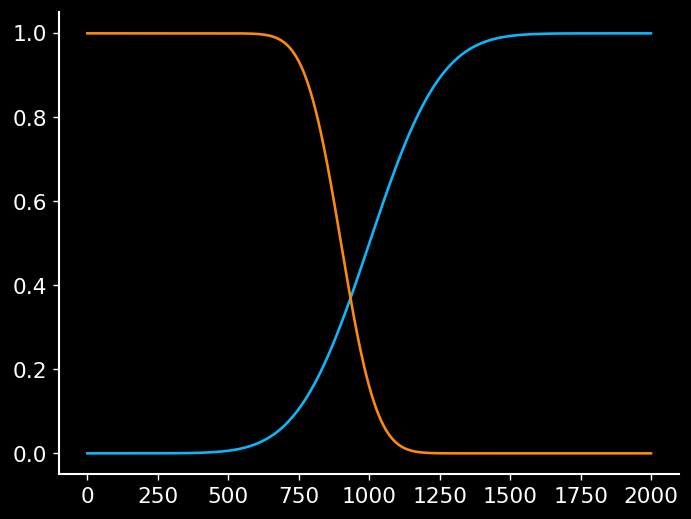

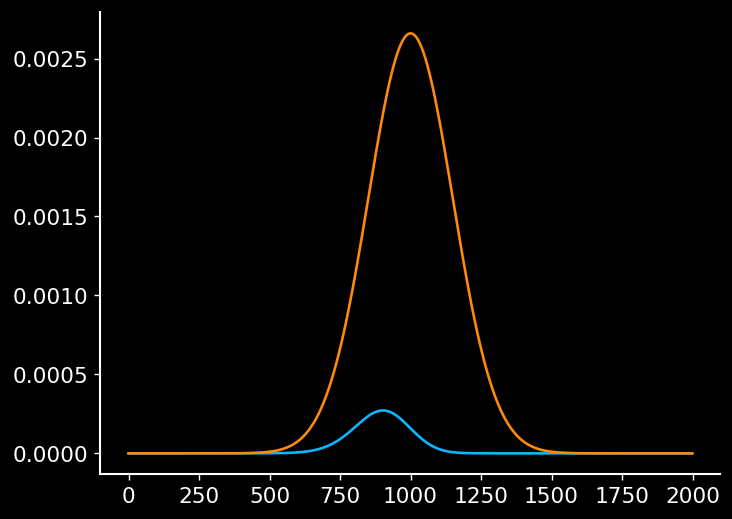

In [ ]:
cutoff_time,cutoff_sd = 900,100
agent_mean,agent_sd = 1000,200
prob_A_less_than_t = stats.norm.cdf(timesteps,agent_mean,agent_sd)
prob_T_greater_than_t = 1- stats.norm.cdf(timesteps,cutoff_time,cutoff_sd)
new_dist = agent_pdf*((prob_A_less_than_t*prob_T_greater_than_t))
plt.plot(prob_A_less_than_t)
plt.plot(prob_T_greater_than_t)
fig,ax = plt.subplots()
ax.plot(new_dist)
ax.plot(agent_dist)

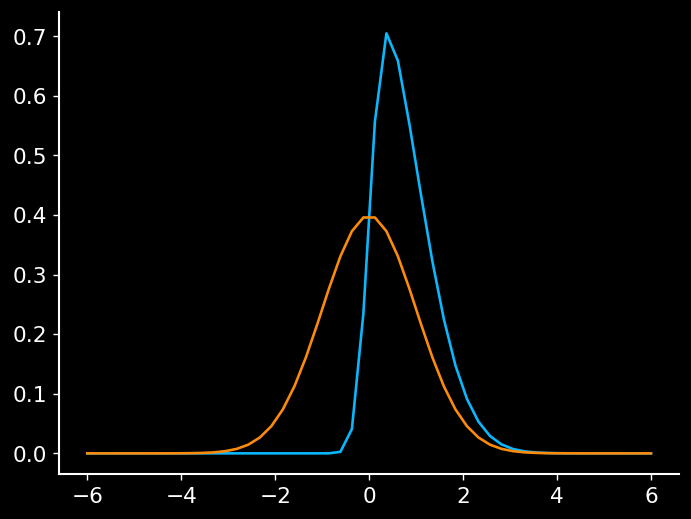

In [ ]:
nums = np.linspace(-6,6)
r = -0.9
f = 2*stats.norm.pdf(nums)*stats.norm.cdf(nums*((1-r)/(np.sqrt(1-r**2))))
f_r0 = 2*stats.norm.pdf(nums)*stats.norm.cdf(0)
plt.plot(nums,f)
plt.plot(nums,f_r0)

In [ ]:
stats.norm.cdf(0)

0.5